### Actividad de perceptrón y perceptrón multicapa
#### Autor: Francisco Serradilla

Tareas:

- Escribir el código de propagación y actualización de pesos del perceptrón.
- Escribir el código de propagación y actualización de pesos del perceptrón multicapa para una capa oculta.
- Probar el correcto funcionamiento con OR y con XOR.
- Probar el correcto funcionamiento para las distribuciones generadas en el notebook. Dibujar los resultados.

Opcional:
- Problema de clasificación de orquídeas.
- Ampliar el código del perceptrón Multicapa para calcular el error de test usando otro conjunto de datos. Este error de test se irá mostrando a la vez que el error de entrenamiento mientras la red se entrena.
- Probar entrenamiento y cálculo del error de test con el juego de datos de aprobados.
- (hacer al menos dos) Probar con problemas adicionales (circulo, fun, morosos, quinielas). Al final hay una explicación de los conjuntos de datos suministrados.
- (opcional) Añadir una segunda capa oculta al perceptrón multacapa y/o un múmero indefinido de capas.

In [6]:
import numpy as np

class Perceptron:
    def __init__(self, ninput, noutput):
        self.ninput = ninput # número de entradas
        self.noutput = noutput # número de salidas
        self.w = np.random.rand(ninput,noutput)-0.5 # pesos
        self.b = np.random.rand(noutput)-0.5 # bias

    def step (self, x): # función de activación
        return np.where(x<0,0,1) 

    def forward (self, x): # propaga un vector x y devuelve la salida
        z = np.dot(x, self.w) + self.b 
        return self.step(z)

    def update (self, x, d, alpha): # realiza una iteración de entrenamiento
        s = self.forward(x) # propaga
        # self.w = self.w + alpha*np.outer(x,d-s) # ajusta pesos
        self.w = self.w + alpha * (x*(d-s)).reshape(self.ninput,self.noutput) # ajusta pesos
        
        self.b = self.b + alpha*(d-s)

    def RMS (self, X, D): # calcula el error RMS
        S = self.forward(X)
        return np.mean(np.sqrt(np.mean(np.square(S-D),axis=1)))

    def accuracy (self, X, D): # calcula el ratio de aciertos
        S = self.forward(X)
        errors = np.mean(np.abs(D-S))
        return 1.0 - errors

    def info (self, X, D): # traza de cómno va el entrenamiento
        print(f'RMS: {self.RMS(X,D):.4f}')
        print(f'Accuracy: {self.accuracy(X,D):.4f}')

    def train (self, X, D, alpha, epochs, trace=0): # entrena usando update
        for e in range(1,epochs+1): # para cada epoch
            for i in range(len(X)): # para cada ejemplo
                self.update(X[i],D[i], alpha)
            if trace!=0 and e%trace == 0: # imprime trazas
                print('\n   Epoch: %d' % e)
                self.info(X,D)

In [7]:
# entrena para la OR

p = Perceptron(ninput=2,noutput=1)

# or
data = np.array([[0.0, 0.0], [0.0, 1.0], [1.0, 0.0], [1.0, 1.0]])
labels = np.array([[0.0], [1.0], [1.0], [1.0]])

p.train(data, labels, alpha=0.1, epochs=50, trace=10)
p.info(data, labels)


   Epoch: 10
RMS: 0.0000
Accuracy: 1.0000

   Epoch: 20
RMS: 0.0000
Accuracy: 1.0000

   Epoch: 30
RMS: 0.0000
Accuracy: 1.0000

   Epoch: 40
RMS: 0.0000
Accuracy: 1.0000

   Epoch: 50
RMS: 0.0000
Accuracy: 1.0000
RMS: 0.0000
Accuracy: 1.0000


In [48]:
class Multilayer:
    def __init__(self, layers):
        """
        layers: List of integers representing the number of neurons in each layer.
                For example, [3, 5, 4, 2] represents a network with:
                - 3 input neurons
                - 5 neurons in the first hidden layer
                - 4 neurons in the second hidden layer
                - 2 output neurons
        """
        self.layers = layers
        self.num_layers = len(layers)
        
        # Initialize weights and biases
        self.weights = []
        self.biases = []
        for i in range(self.num_layers - 1):
            self.weights.append(np.random.rand(layers[i], layers[i + 1]) - 0.5)
            self.biases.append(np.random.rand(layers[i + 1]) - 0.5)
        
        self.lRMS = []
        self.laccuracy = []
        self.lRMS_test = []
        self.laccuracy_test = []

    def sigm(self, neta):
        return 1.0 / (1.0 + np.exp(-neta))

    def forward(self, x):
        activations = [x]
        for i in range(self.num_layers - 1):
            neta = np.dot(activations[-1], self.weights[i]) + self.biases[i]
            activations.append(self.sigm(neta))
        return activations[-1]

    def update(self, x, d, alpha):
        activations = [x]
        for i in range(self.num_layers - 1):
            neta = np.dot(activations[-1], self.weights[i]) + self.biases[i]
            activations.append(self.sigm(neta))
        
        # Backpropagation
        deltas = [d - activations[-1]]
        for i in range(self.num_layers - 2, 0, -1):
            deltas.append(np.dot(deltas[-1], self.weights[i].T) * activations[i] * (1 - activations[i]))
        deltas.reverse()
        
        # Update weights and biases
        for i in range(self.num_layers - 1):
            self.weights[i] += alpha * np.outer(activations[i], deltas[i])
            self.biases[i] += alpha * deltas[i]

    def RMS(self, X, D):
        S = self.forward(X)
        return np.mean(np.sqrt(np.mean(np.square(S - D), axis=1)))

    def accuracy(self, X, D):
        S = self.forward(X)
        S = np.round(S)
        errors = np.mean(np.abs(D - S))
        return 1.0 - errors

    def info(self, X, D, X_test=None, D_test=None):
        self.lRMS.append(self.RMS(X, D))
        self.laccuracy.append(self.accuracy(X, D))
        print('     RMS: %6.5f' % self.lRMS[-1])
        print('Accuracy: %6.5f' % self.laccuracy[-1])
        
        if X_test is not None and D_test is not None:
            self.lRMS_test.append(self.RMS(X_test, D_test))
            self.laccuracy_test.append(self.accuracy(X_test, D_test))
            print('     RMS Test: %6.5f' % self.lRMS_test[-1])
            print('Accuracy Test: %6.5f' % self.laccuracy_test[-1])

    def train(self, X, D, alpha, epochs, trace=0, X_test=None, D_test=None):
        self.lRMS = []
        self.laccuracy = []
        self.lRMS_test = []
        self.laccuracy_test = []

        for e in range(1, epochs + 1):
            for i in range(len(X)):
                self.update(X[i], D[i], alpha)
            if trace != 0 and e % trace == 0:
                print('\n   Epoch: %d' % e)
                self.info(X, D, X_test, D_test)
                
def one_hot (d): # codificación one_hot
    num_classes = len(set(d))
    rows = d.shape[0]
    labels = np.zeros((rows, num_classes), dtype='float32')
    labels[np.arange(rows),d.T] = 1
    return labels

In [50]:
# xor
import numpy as np
data = np.array([[0.0, 0.0], [0.0, 1.0], [1.0, 0.0], [1.0, 1.0]])
labels = np.array([[0.0], [1.0], [1.0], [0.0]])

p = Multilayer([2,2,1])

p.info(data, labels)


     RMS: 0.49999
Accuracy: 0.50000


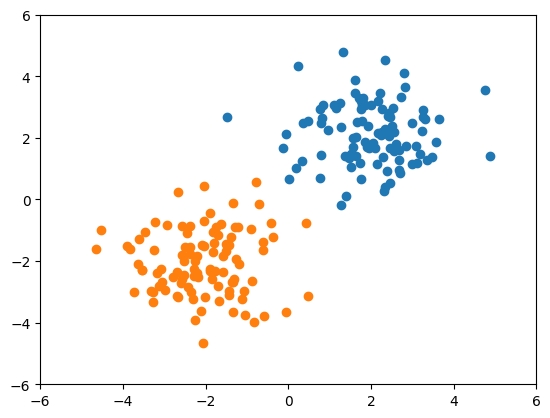

In [51]:
import numpy as np

# example data from two classes; 2D normal distributions
num = 100
x0 = np.random.multivariate_normal([2,2], np.array([[1,0],[0,1]]),num)
d0 = np.repeat(0, num)
x1 = np.random.multivariate_normal([-2,-2], np.array([[1,0],[0,1]]),num)
d1 = np.repeat(1, num)

import matplotlib.pyplot as plt
plt.xlim(-6,6)
plt.ylim(-6,6)
plt.plot(x0[:,0],x0[:,1],'o')
plt.plot(x1[:,0],x1[:,1],'o')

plt.show()

X = np.vstack((x0,x1))
d = np.hstack((d0,d1))
d.shape = (200,1) # convierte el vector en un array

In [53]:
# entrenar

p = Perceptron(2,1)
p.train(X, d, 0.01, 10, 1)


   Epoch: 1
RMS: 0.0050
Accuracy: 0.9950

   Epoch: 2
RMS: 0.0050
Accuracy: 0.9950

   Epoch: 3
RMS: 0.0050
Accuracy: 0.9950

   Epoch: 4
RMS: 0.0000
Accuracy: 1.0000

   Epoch: 5
RMS: 0.0000
Accuracy: 1.0000

   Epoch: 6
RMS: 0.0000
Accuracy: 1.0000

   Epoch: 7
RMS: 0.0000
Accuracy: 1.0000

   Epoch: 8
RMS: 0.0000
Accuracy: 1.0000

   Epoch: 9
RMS: 0.0000
Accuracy: 1.0000

   Epoch: 10
RMS: 0.0000
Accuracy: 1.0000


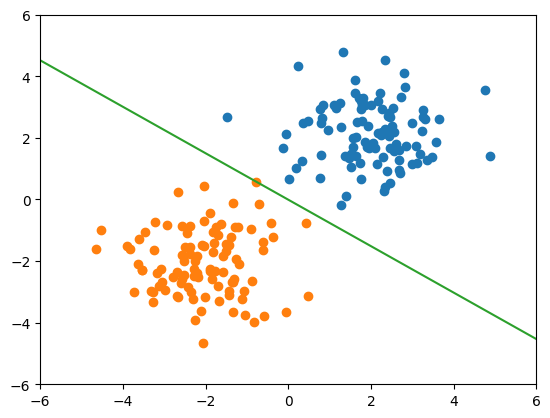

In [54]:
# Dibujar el resultado de la clasificación por el perceptrón
import numpy as np
import matplotlib.pyplot as plt
x_line = np.linspace(-6,6,100)
y_line = -p.w[0]/p.w[1]*x_line - p.b/p.w[1]
plt.xlim(-6,6)
plt.ylim(-6,6)
plt.plot(x0[:,0],x0[:,1],'o')
plt.plot(x1[:,0],x1[:,1],'o')
plt.plot(x_line, y_line)

plt.show()

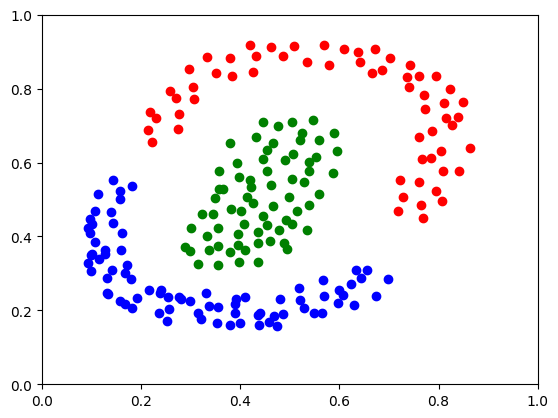

In [55]:
# regiones no lineales

X = np.loadtxt('samples/data_3classes_nonlinear_2D.txt')

d = X[:,-1].astype('int')
X = X[:,:-1]

plt.figure()
plt.xlim(0,1)
plt.ylim(0,1)
plt.plot(X[d==0,0],X[d==0,1], 'ro')
plt.plot(X[d==1,0],X[d==1,1], 'go')
plt.plot(X[d==2,0],X[d==2,1], 'bo')

plt.show()

no = len(set(d))
ni = X.shape[1]

d = one_hot(d)

In [56]:
import pickle
# entrenar
# encontrar arquitectura mínima que aprende este problema, para data_2classes_nonlinear_2D.txt y para data_3classes_nonlinear_2D.txt
for i in range(1, 10):
    print(i)
    p = Multilayer([ni, i, no])
    p.train(X, d, alpha=0.1, epochs=1000, trace=100)
    if p.accuracy(X, d) == 1:
        print(f'Arquitectura mínima: {i}')
        pickle.dump(p, open(f'./models/data_3classes_nonlinear_2D.pkl', 'wb'))
        break

1

   Epoch: 100
     RMS: 0.33897
Accuracy: 0.69683

   Epoch: 200
     RMS: 0.33107
Accuracy: 0.69683

   Epoch: 300
     RMS: 0.32796
Accuracy: 0.69841

   Epoch: 400
     RMS: 0.32644
Accuracy: 0.69841

   Epoch: 500
     RMS: 0.32554
Accuracy: 0.69841

   Epoch: 600
     RMS: 0.32492
Accuracy: 0.69841

   Epoch: 700
     RMS: 0.32442
Accuracy: 0.69841

   Epoch: 800
     RMS: 0.32400
Accuracy: 0.69841

   Epoch: 900
     RMS: 0.32362
Accuracy: 0.70000

   Epoch: 1000
     RMS: 0.32327
Accuracy: 0.70000
2

   Epoch: 100
     RMS: 0.32887
Accuracy: 0.69524

   Epoch: 200
     RMS: 0.26895
Accuracy: 0.79841

   Epoch: 300
     RMS: 0.25478
Accuracy: 0.80635

   Epoch: 400
     RMS: 0.24990
Accuracy: 0.82063

   Epoch: 500
     RMS: 0.24719
Accuracy: 0.82381

   Epoch: 600
     RMS: 0.24549
Accuracy: 0.82381

   Epoch: 700
     RMS: 0.24452
Accuracy: 0.82540

   Epoch: 800
     RMS: 0.24406
Accuracy: 0.82540

   Epoch: 900
     RMS: 0.24390
Accuracy: 0.82540

   Epoch: 1000
     RMS: 

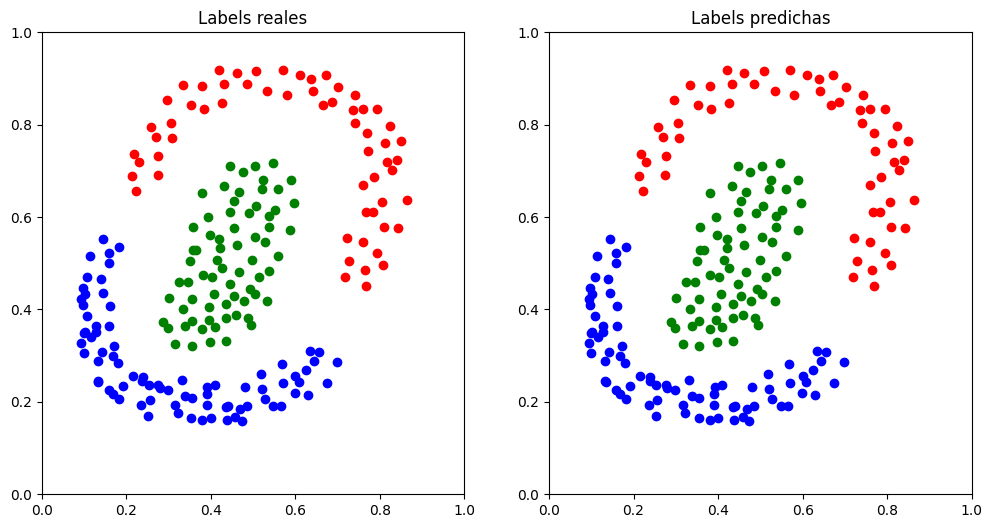

In [57]:
# Dibujar el resultado de la clasificación por el multicapa, comparar con las salidas que debería dar
p = pickle.load(open(f'./models/data_3classes_nonlinear_2D.pkl', 'rb'))
# Propagar las entradas
predictions = p.forward(X)

# Clasificar las predicciones cogiendo el índice de la neurona con mayor valor.
predicted_labels = np.argmax(predictions, axis=1)

# Clasificar las salidas reales cogiendo el índice de la neurona con valor 1.
true_labels = np.argmax(d, axis=1)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the true labels
axs[0].set_xlim(0, 1)
axs[0].set_ylim(0, 1)
axs[0].plot(X[true_labels == 0, 0], X[true_labels == 0, 1], 'ro')
axs[0].plot(X[true_labels == 1, 0], X[true_labels == 1, 1], 'go')
axs[0].plot(X[true_labels == 2, 0], X[true_labels == 2, 1], 'bo')
axs[0].set_title('Labels reales')

# Plot the predicted labels
axs[1].set_xlim(0, 1)
axs[1].set_ylim(0, 1)
axs[1].plot(X[predicted_labels == 0, 0], X[predicted_labels == 0, 1], 'ro')
axs[1].plot(X[predicted_labels == 1, 0], X[predicted_labels == 1, 1], 'go')
axs[1].plot(X[predicted_labels == 2, 0], X[predicted_labels == 2, 1], 'bo')
axs[1].set_title('Labels predichas')

plt.show()

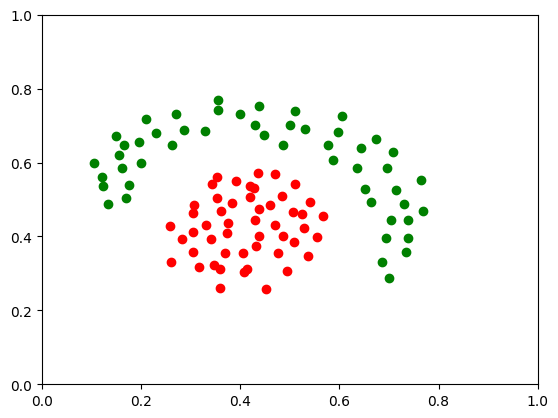

In [58]:
# regiones no lineales

X = np.loadtxt('samples/data_2classes_nonlinear_2D.txt')

d = X[:,-1].astype('int')
X = X[:,:-1]

plt.figure()
plt.xlim(0,1)
plt.ylim(0,1)
plt.plot(X[d==0,0],X[d==0,1], 'ro')
plt.plot(X[d==1,0],X[d==1,1], 'go')
plt.plot(X[d==2,0],X[d==2,1], 'bo')

plt.show()

no = len(set(d))
ni = X.shape[1]

d = one_hot(d)

In [59]:
import pickle
# entrenar
# encontrar arquitectura mínima que aprende este problema, para data_2classes_nonlinear_2D.txt y para data_3classes_nonlinear_2D.txt
for i in range(1, 10):
    print(i)
    p = Multilayer([ni, i, no])
    p.train(X, d, alpha=0.1, epochs=1000, trace=100)
    if p.accuracy(X, d) == 1:
        print(f'Arquitectura mínima: {i}')
        pickle.dump(p, open(f'./models/data_2classes_nonlinear_2D.pkl', 'wb'))
        break

1

   Epoch: 100
     RMS: 0.29003
Accuracy: 0.75000

   Epoch: 200
     RMS: 0.26684
Accuracy: 0.78000

   Epoch: 300
     RMS: 0.26211
Accuracy: 0.79000

   Epoch: 400
     RMS: 0.26082
Accuracy: 0.79000

   Epoch: 500
     RMS: 0.26040
Accuracy: 0.80000

   Epoch: 600
     RMS: 0.26028
Accuracy: 0.79000

   Epoch: 700
     RMS: 0.26030
Accuracy: 0.79000

   Epoch: 800
     RMS: 0.26037
Accuracy: 0.79000

   Epoch: 900
     RMS: 0.26045
Accuracy: 0.79000

   Epoch: 1000
     RMS: 0.26053
Accuracy: 0.79000
2

   Epoch: 100
     RMS: 0.28473
Accuracy: 0.75000

   Epoch: 200
     RMS: 0.04348
Accuracy: 1.00000

   Epoch: 300
     RMS: 0.01800
Accuracy: 1.00000

   Epoch: 400
     RMS: 0.01167
Accuracy: 1.00000

   Epoch: 500
     RMS: 0.00868
Accuracy: 1.00000

   Epoch: 600
     RMS: 0.00691
Accuracy: 1.00000

   Epoch: 700
     RMS: 0.00574
Accuracy: 1.00000

   Epoch: 800
     RMS: 0.00490
Accuracy: 1.00000

   Epoch: 900
     RMS: 0.00428
Accuracy: 1.00000

   Epoch: 1000
     RMS: 

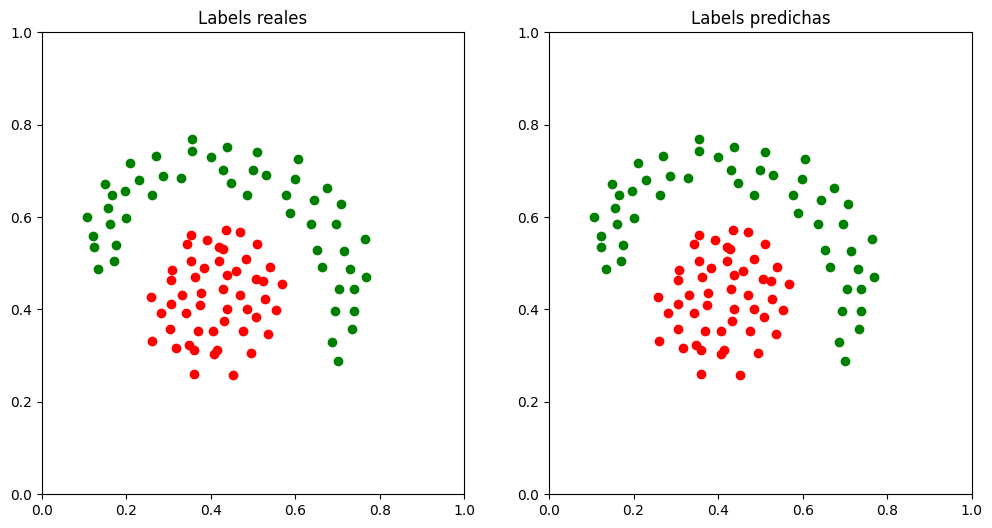

In [60]:
# Dibujar el resultado de la clasificación por el multicapa, comparar con las salidas que debería dar
p = pickle.load(open(f'./models/data_2classes_nonlinear_2D.pkl', 'rb'))
# Propagate the inputs through the network
predictions = p.forward(X)
# print(predictions)
# Clasificar las predicciones cogiendo el índice de la neurona con mayor valor.
predicted_labels = np.argmax(predictions, axis=1)

# Clasificar las salidas reales cogiendo el índice de la neurona con valor 1.
true_labels = np.argmax(d, axis=1)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the true labels
axs[0].set_xlim(0, 1)
axs[0].set_ylim(0, 1)
axs[0].plot(X[true_labels == 0, 0], X[true_labels == 0, 1], 'ro')
axs[0].plot(X[true_labels == 1, 0], X[true_labels == 1, 1], 'go')
axs[0].plot(X[true_labels == 2, 0], X[true_labels == 2, 1], 'bo')
axs[0].set_title('Labels reales')

# Plot the predicted labels
axs[1].set_xlim(0, 1)
axs[1].set_ylim(0, 1)
axs[1].plot(X[predicted_labels == 0, 0], X[predicted_labels == 0, 1], 'ro')
axs[1].plot(X[predicted_labels == 1, 0], X[predicted_labels == 1, 1], 'go')
axs[1].plot(X[predicted_labels == 2, 0], X[predicted_labels == 2, 1], 'bo')
axs[1].set_title('Labels predichas')

plt.show()

## Problema de clasificacíon de orquídeas.

In [74]:
# Orquideas

X = np.loadtxt('samples/iris.csv', dtype = 'float64', usecols = [0,1,2,3])
L = np.loadtxt('samples/iris.csv', dtype = str, usecols = [4]) 

# convierte la salida a enteros
d = []
options = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
for e in L:
    d.append(options.index(e))

d = np.array(d)
X = np.array(X)

d = one_hot(d)

ni = X.shape[1]
no = len(options)

# encontrar arquitectura mínima que aprende este problema
import pickle
# entrenar
# encontrar arquitectura mínima que aprende este problema, para data_2classes_nonlinear_2D.txt y para data_3classes_nonlinear_2D.txt
for i in range(1, 10):
    print(i)
    p = Multilayer([ni, i, no])
    p.train(X, d, alpha=0.05, epochs=5000, trace=100)
    if p.accuracy(X, d) >= 0.99:
        print(f'Arquitectura mínima: {i}')
        pickle.dump(p, open(f'./models/iris.pkl', 'wb'))
        break

1

   Epoch: 100
     RMS: 0.35220
Accuracy: 0.67556

   Epoch: 200
     RMS: 0.31397
Accuracy: 0.72889

   Epoch: 300
     RMS: 0.29547
Accuracy: 0.75556

   Epoch: 400
     RMS: 0.29541
Accuracy: 0.75333

   Epoch: 500
     RMS: 0.29245
Accuracy: 0.75556

   Epoch: 600
     RMS: 0.29715
Accuracy: 0.75111

   Epoch: 700
     RMS: 0.29189
Accuracy: 0.75778

   Epoch: 800
     RMS: 0.29334
Accuracy: 0.75778

   Epoch: 900
     RMS: 0.29690
Accuracy: 0.75111

   Epoch: 1000
     RMS: 0.29620
Accuracy: 0.75556

   Epoch: 1100
     RMS: 0.29227
Accuracy: 0.76000

   Epoch: 1200
     RMS: 0.29306
Accuracy: 0.76000

   Epoch: 1300
     RMS: 0.29278
Accuracy: 0.76222

   Epoch: 1400
     RMS: 0.29647
Accuracy: 0.75778

   Epoch: 1500
     RMS: 0.29941
Accuracy: 0.76000

   Epoch: 1600
     RMS: 0.29908
Accuracy: 0.76000

   Epoch: 1700
     RMS: 0.29861
Accuracy: 0.76000

   Epoch: 1800
     RMS: 0.30514
Accuracy: 0.75111

   Epoch: 1900
     RMS: 0.29778
Accuracy: 0.76000

   Epoch: 2000
   

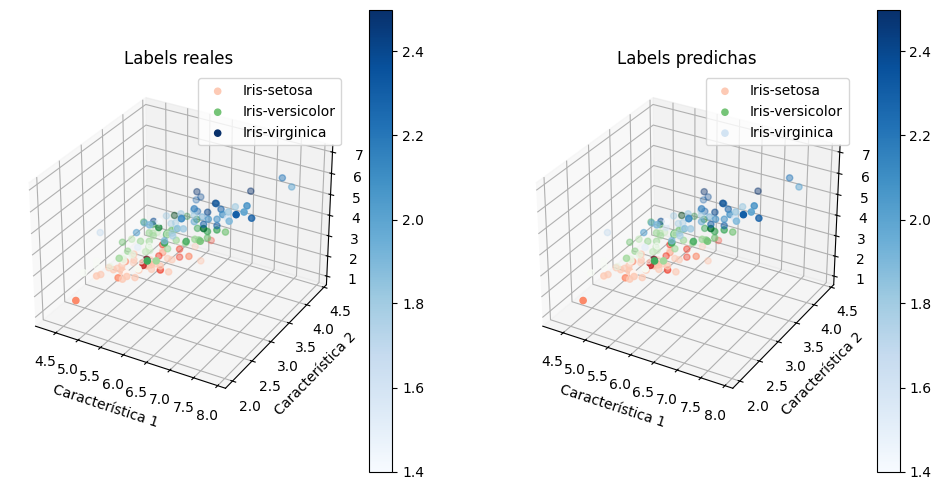

In [75]:
from mpl_toolkits.mplot3d import Axes3D

# Dibujar el resultado de la clasificación por el multicapa, comparar con las salidas que debería dar
p = pickle.load(open(f'./models/iris.pkl', 'rb'))
# Propagar las entradas
predictions = p.forward(X)

# Clasificar las predicciones cogiendo el índice de la neurona con mayor valor.
predicted_labels = np.argmax(predictions, axis=1)

# Clasificar las salidas reales cogiendo el índice de la neurona con valor 1.
true_labels = np.argmax(d, axis=1)

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(121, projection='3d')

# Plot the true labels
sc = ax.scatter(X[true_labels == 0, 0], X[true_labels == 0, 1], X[true_labels == 0, 2], c=X[true_labels == 0, 3], cmap='Reds', label='Iris-setosa')
sc = ax.scatter(X[true_labels == 1, 0], X[true_labels == 1, 1], X[true_labels == 1, 2], c=X[true_labels == 1, 3], cmap='Greens', label='Iris-versicolor')
sc = ax.scatter(X[true_labels == 2, 0], X[true_labels == 2, 1], X[true_labels == 2, 2], c=X[true_labels == 2, 3], cmap='Blues', label='Iris-virginica')

ax.set_xlabel('Característica 1')
ax.set_ylabel('Característica 2')
ax.set_zlabel('Característica 3')
ax.set_title('Labels reales')
ax.legend()

plt.colorbar(sc)

ax = fig.add_subplot(122, projection='3d')

# Plot the predicted labels
sc = ax.scatter(X[predicted_labels == 0, 0], X[predicted_labels == 0, 1], X[predicted_labels == 0, 2], c=X[predicted_labels == 0, 3], cmap='Reds', label='Iris-setosa')
sc = ax.scatter(X[predicted_labels == 1, 0], X[predicted_labels == 1, 1], X[predicted_labels == 1, 2], c=X[predicted_labels == 1, 3], cmap='Greens', label='Iris-versicolor')
sc = ax.scatter(X[predicted_labels == 2, 0], X[predicted_labels == 2, 1], X[predicted_labels == 2, 2], c=X[predicted_labels == 2, 3], cmap='Blues', label='Iris-virginica')

ax.set_xlabel('Característica 1')
ax.set_ylabel('Característica 2')
ax.set_zlabel('Característica 3')
ax.set_title('Labels predichas')
ax.legend()

plt.colorbar(sc)
plt.show()


### Explicación de los archivos de datos suministrados

**Nota**: en caso de que se suministre archivo xxx-trn.txt y xxx-tst.txt, se deberá entrenar con el trn y calcular luego el error de test con el tst. Lógicamente queremos un modelo cuyo error de test sea lo más bajo posible. Si no se suministra archivo de test no es necesario dividir en entrenamiento y test, y lo que se busca es el error más bajo en entrenamiento.

#### Aprobados

Contiene 3 entradas, correspondiente a la nota en 3 ejercicios, y 1 salida, que indica si el alumno aprobó o no. Se trataría de predecir si un alumno va a aprobar a partir de sus notas. Es un problema de clasificación.

Cuestiones: ¿Es un problema lineal? ¿Puede aprenderla una red de neuronas?
<li>Parece un problema en el que simplemente habria que calcular los porcentajes a que equivale cada una de las notas sobre la media que es el aprobado o no, una red de neuronas tendría que ajustar los pesos que correspondería a esos porcentajes.</li>

#### Fun

Contiene 1 entrada y 1 salida, que son la *x* y la *y* de una función desconocida. Es un problema de ajuste o regresión.

Cuestiones: ¿Es una función lineal? ¿Puede aprenderla una red de neuronas? ¿Puede decirnos la red qué función es?

#### Morosos

Contiene datos de morosidad de un banco. La idea es predecir si un nuevo cliente va a devolver un prestamo o no y utilizar esta predicción para concederle o denegarle el préstamo. Es un problema de clasificación.

Tiene 9 entradas y 1 salida.

Cuestiones: ¿Es una función lineal? ¿Cuál es el porcentaje de acierto estimado en test?

#### Quinielas

Contiene datos de quinielas deportivas. Tiene 60 entradas y 3 salidas (1, X, 2). Es un problema de clasificación.

Cuestiones: ¿Cuál es el porcentaje de acierto estimado en test?

#### Sensores

Contiene datos de sensores y velocidades medias en la M-40. La idea es ver si se puede predecir la velocidad media en un punto que no tiene sensor a partir de las lecturas de los sensores en otros puntos. Es un problema de ajuste o regresión.

Cuestiones: ¿Cuál es el porcentaje de acierto estimado en test?

#### Circulo

Es un problema de clasificación con 3 regiones concéntricas. No tiene conjunto de test, el objetivo es encontrar la red mínima que pueda clasificar correctamente todos los ejemplos.

#### Encoder

Es el problema clásico de utilizar una capa oculta para codificar patrones de 8 valores en una dimensión menor. El objetivo es entrenar un perceptrón 8-3-8 para que aprenda esta codificación en el 100% de los ejemplos.  Es un problema de clasificación.

#### Pima-diabetes

Contiene resultados de un conjunto de análisis y pruebas en personas que posteriormente desarrollaron o no diabetes. La idea es ver si se puede predecir si una persona va a desarrollar la enfermedad en el futuro.

En este caso hay que separar aleatoriamente un 30% de ejemplos para tener una conjunto de test. Nota: se sugiere usar la función shuffle.

Cuestiones: ¿Cuál es el porcentaje de acierto estimado en test?

## Datos aprobados

In [76]:
# Cargar datos de entrenamiento y test desde archivos
data_train = np.loadtxt('./samples/aprobado-ent.txt')
data_test = np.loadtxt('./samples/aprobado-tst.txt')

# Separar características y etiquetas
X_train = data_train[:, :-1]
y_train = data_train[:, -1].reshape(-1, 1)
X_test = data_test[:, :-1]
y_test = data_test[:, -1].reshape(-1, 1)

# Entrenar el modelo con los datos de aprobados
p = Multilayer([3,5,1]) 
p.train(X_train, y_train, alpha=0.05, epochs=1500, trace=100, X_test=X_test, D_test=y_test)


   Epoch: 100
     RMS: 0.12342
Accuracy: 0.95918
     RMS Test: 0.16820
Accuracy Test: 0.89796

   Epoch: 200
     RMS: 0.04387
Accuracy: 0.97959
     RMS Test: 0.06981
Accuracy Test: 0.95918

   Epoch: 300
     RMS: 0.04956
Accuracy: 0.95918
     RMS Test: 0.09323
Accuracy Test: 0.91837

   Epoch: 400
     RMS: 0.03920
Accuracy: 0.97959
     RMS Test: 0.08148
Accuracy Test: 0.93878

   Epoch: 500
     RMS: 0.02889
Accuracy: 0.97959
     RMS Test: 0.06629
Accuracy Test: 0.93878

   Epoch: 600
     RMS: 0.01637
Accuracy: 1.00000
     RMS Test: 0.04165
Accuracy Test: 0.95918

   Epoch: 700
     RMS: 0.01219
Accuracy: 1.00000
     RMS Test: 0.03203
Accuracy Test: 0.97959

   Epoch: 800
     RMS: 0.00952
Accuracy: 1.00000
     RMS Test: 0.02615
Accuracy Test: 0.97959

   Epoch: 900
     RMS: 0.00752
Accuracy: 1.00000
     RMS Test: 0.02183
Accuracy Test: 1.00000

   Epoch: 1000
     RMS: 0.00593
Accuracy: 1.00000
     RMS Test: 0.01835
Accuracy Test: 1.00000

   Epoch: 1100
     RMS: 0.0

## Función

In [91]:
import numpy as np
# Cargar datos de entrenamiento y test desde archivos
data_train = np.loadtxt('./samples/fun-trn.txt')
data_test = np.loadtxt('./samples/fun-tst.txt')

# Separar características y etiquetas
X_train = data_train[:, :-1]
y_train = data_train[:, -1].reshape(-1, 1)
X_test = data_test[:, :-1]
y_test = data_test[:, -1].reshape(-1, 1)

# Entrenar el modelo
p = Multilayer([1, 4, 6, 1])
p.train(X_train, y_train, alpha=0.1, epochs=5000, trace=100, X_test=X_test, D_test=y_test)


   Epoch: 100
     RMS: 0.13762
Accuracy: 0.80576
     RMS Test: 0.13392
Accuracy Test: 0.80841

   Epoch: 200
     RMS: 0.08813
Accuracy: 0.80950
     RMS Test: 0.08554
Accuracy Test: 0.81599

   Epoch: 300
     RMS: 0.07498
Accuracy: 0.81170
     RMS Test: 0.07336
Accuracy Test: 0.81599

   Epoch: 400
     RMS: 0.07407
Accuracy: 0.81170
     RMS Test: 0.07260
Accuracy Test: 0.81599

   Epoch: 500
     RMS: 0.07289
Accuracy: 0.80950
     RMS Test: 0.07100
Accuracy Test: 0.81599

   Epoch: 600
     RMS: 0.07123
Accuracy: 0.81170
     RMS Test: 0.06931
Accuracy Test: 0.81599

   Epoch: 700
     RMS: 0.06986
Accuracy: 0.81170
     RMS Test: 0.06791
Accuracy Test: 0.81599

   Epoch: 800
     RMS: 0.06889
Accuracy: 0.81170
     RMS Test: 0.06681
Accuracy Test: 0.81599

   Epoch: 900
     RMS: 0.06779
Accuracy: 0.81170
     RMS Test: 0.06571
Accuracy Test: 0.81744

   Epoch: 1000
     RMS: 0.06665
Accuracy: 0.81170
     RMS Test: 0.06438
Accuracy Test: 0.81744

   Epoch: 1100
     RMS: 0.0

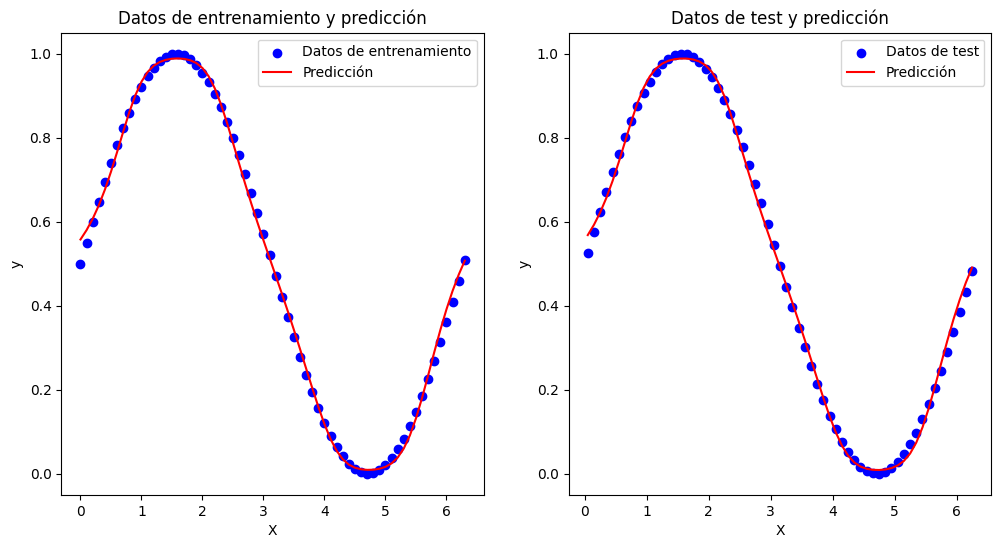

In [93]:

# Predicciones
y_pred_train = p.forward(X_train)
y_pred_test = p.forward(X_test)

# Graficar la función original y la predicción
plt.figure(figsize=(12, 6))

# Datos de entrenamiento
plt.subplot(1, 2, 1)
plt.scatter(X_train, y_train, color='blue', label='Datos de entrenamiento')
plt.plot(X_train, y_pred_train, color='red', label='Predicción')
plt.title('Datos de entrenamiento y predicción')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()

# Datos de test
plt.subplot(1, 2, 2)
plt.scatter(X_test, y_test, color='blue', label='Datos de test')
plt.plot(X_test, y_pred_test, color='red', label='Predicción')
plt.title('Datos de test y predicción')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()

plt.show()

In [103]:
import numpy as np

# Cargar datos de entrenamiento y test desde archivos
data_train = np.loadtxt('./samples/morosos-ent.txt')
data_test = np.loadtxt('./samples/morosos-tst.txt')

# Separar características y etiquetas
X_train = data_train[:, :-1]
y_train = data_train[:, -1].reshape(-1, 1)
X_test = data_test[:, :-1]
y_test = data_test[:, -1].reshape(-1, 1)

# Entrenar el modelo
p = Multilayer([9, 20, 10, 1])
p.train(X_train, y_train, alpha=0.1, epochs=1000, trace=100, X_test=X_test, D_test=y_test)


   Epoch: 100
     RMS: 0.24795
Accuracy: 0.83175
     RMS Test: 0.31623
Accuracy Test: 0.75146

   Epoch: 200
     RMS: 0.16192
Accuracy: 0.89417
     RMS Test: 0.29976
Accuracy Test: 0.72807

   Epoch: 300
     RMS: 0.10385
Accuracy: 0.92537
     RMS Test: 0.30430
Accuracy Test: 0.71053

   Epoch: 400
     RMS: 0.07699
Accuracy: 0.94301
     RMS Test: 0.29586
Accuracy Test: 0.71053

   Epoch: 500
     RMS: 0.05929
Accuracy: 0.96201
     RMS Test: 0.31489
Accuracy Test: 0.68713

   Epoch: 600
     RMS: 0.04467
Accuracy: 0.97015
     RMS Test: 0.30361
Accuracy Test: 0.69883

   Epoch: 700
     RMS: 0.04149
Accuracy: 0.97286
     RMS Test: 0.29898
Accuracy Test: 0.70760

   Epoch: 800
     RMS: 0.05695
Accuracy: 0.95387
     RMS Test: 0.31179
Accuracy Test: 0.69006

   Epoch: 900
     RMS: 0.02627
Accuracy: 0.98915
     RMS Test: 0.30089
Accuracy Test: 0.70468

   Epoch: 1000
     RMS: 0.02063
Accuracy: 0.98915
     RMS Test: 0.29108
Accuracy Test: 0.70760


Vemos que va mucho mejor con tan solo 100 epochs para el test, ya que así no tiene overfitting. Ponemos 100 epochs.

In [ ]:
p = Multilayer([9, 20, 10, 1])
p.train(X_train, y_train, alpha=0.1, epochs=100, trace=100, X_test=X_test, D_test=y_test)


   Epoch: 100
     RMS: 0.24153
Accuracy: 0.83446
     RMS Test: 0.30361
Accuracy Test: 0.76316


### Introducción a pytorch

Características:
  * Creado por FaceBook en 2017 fusionando las librerías torch y caffe.
  * Es de código abierto.
  * Incluye computación basada en tensores (similar a numpy) y con soporte de GPU, incluidas NVidia, AMD y Apple silicon.
  * Incluye componentes para Redes de Neuronas y Deep Learning, tanto secuenciales como funcionales.

Ventajas frente a tensorflow
 * Mayor comunidad; se adapta más rápido a las nuevas versiones de python.
 * No propietario, fuentes disponibles.
 * Soporte a GPU en AMD y Mac Silicon.
 * La documentación es MUY buena.
 * Es más claro el proceso de enviar y recibir objetos a la GPU.
 * Es más eficiente para el aprendizaje por refuerzo.
 * Ligeramente de más alto nivel que tensorflow, pero por debajo de keras.

Desventajas
  * No es de tan alto nivel como Keras:
    * Requiere la implementación del bucle train.
    * Requiere especificar en más detalle la arquitectura secuencial.
    * Requiere calcular dentro del train las métricas de validación.
    * Requiere mover expresamente los objetos a la GPU.
    * Requiere retropropagar expresamente.
    * Requiere indicar expresamente cuáles son los tensores sobre los que aplicar descenso del gradiente.
 
 Descarga y documentación.  
 https://pytorch.org
 
#### Módulos relacionados

  * torchvision: añade recursos para tratamiento de imágenes, incluyendo modelos preentrenados.
  * torchtext: ídem para lenguaje natural.
  * torchaudio: ídem para audio.

#### Enlaces:

  * Tutorial oficial: https://pytorch.org/tutorials/beginner/basics/intro.html
  * Tutorial en youtube: https://www.youtube.com/watch?v=QetoD5LXlEg
  

### Capas básicas en torch.nn:
  * De procesamiento (layers)
    * Linear
    * Conv2d
    * ConvTranspose2d
    * LSTM
    * GRU
    * Transformer
    * Embeeding
  * De activación
    * Sigmoid
    * Tanh
    * ReLU
    * LeakyReLU
    * Softmax
  * Auxiliares
    * Dropout
    * MaxPool2d
    * BatchNorm2d
    * LocalResponseNorm
    * Flatten

### Modelos secuenciales y funcionales

Igual que en tensorflow tenemos los dos tipos de modelos. La elección depende del tipo de red que estemos construyendo.

#### Modelo secuencial

Las capas se van a aplicar secuencialmente una detrás de otra. Podemos especificar las capas en la propia inicialización del modelo Sequential o añadirlas con add_module.
  
```python
self.layers = nn.Sequential(
            nn.Linear(ni, nh),
            nn.Sigmoid(),
            nn.Linear(nh, no)
        )
```

#### Modelo funcional

Tenemos que hacer explícito cómo se aplican las capas dentro del forward.

```python
import torch.functional as F

class LeNet(torch.nn.Module):

    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel (black & white), 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = torch.nn.Conv2d(1, 6, 5) # in_channels, out_channels, kernel_size,
        self.conv2 = torch.nn.Conv2d(6, 16, 3)
        # an affine operation: y = Wx + b
        self.fc1 = torch.nn.Linear(16 * 6 * 6, 120)  # 6*6 from image dimension
        self.fc2 = torch.nn.Linear(120, 84)
        self.fc3 = torch.nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x)) # view es similar a resize, aunque en ciertas condiciones reshape puede crear copia del tensor
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
```


#### Manipulación de tensores: view, reshape, squeeze, unsqueeze

  * view: es el método recomendado para cambiar las dimensiones de un tensor.
  * reshape: similar pero puede ser menos eficiente.
  * unsqueeze: inserta una dimensión de tamaño 1 en la posixión que indiquemos. Por ejemplo torch.unsqueeze(input, dim=1) convierte un vector en una matriz columna.
  * squeeze: elimina las dimensiones de longitud 1, o en la dimensión que se indique como argumento.

In [65]:
%pip install torch

Note: you may need to restart the kernel to use updated packages.


In [66]:
import torch

def set_device ():
    if torch.backends.mps.is_available(): # para usar con mac silicon
        device = "mps"
    elif torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
    torch.set_default_device(device)
    print(f"Using {torch.device(device)} device")
    return torch.device(device)

In [67]:
set_device()

Using cpu device


device(type='cpu')

#### Tarea

Obligatorio

  * Construir un MLP con pytorch para resolver la XOR.
  * Definir la función de trining para entrenarlo.
  * Presentar los resultados.

Opcional
  * Aplicar a los datos suministrados para aproximnar la función seno.
  * Modificar y aplicar a algun otro problema de los suministrados.
  * Modificar la clase basic_MLP para que admita cualquier número de capas. La arquitectura se especificará con una lista [layer1_size, layer2_size, ...]

In [68]:
# Define un MLP básico con una sola capa oculta

from torch import nn

# Define model
class basic_MLP (nn.Module):
    def __init__(self, ni, nh, no):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(ni, nh),
            nn.Sigmoid(),
            nn.Linear(nh, no),
            nn.Sigmoid()
        )

    def forward(self, x):
        output = self.layers(x)
        return output

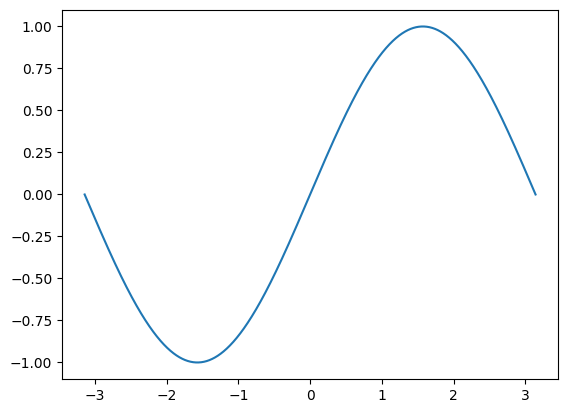

In [69]:
# Ejemplo, crea datos para y = sin(x)

import math
import numpy as np

x = np.linspace(-math.pi, math.pi, 2000, dtype=np.float32)
y = np.sin(x, dtype=np.float32)

%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(x,y)

In [70]:
# convertir tensores numpy a pytorch: torch.from_numpy()
# convertir datos torch a numpy: X.cpu().numpy()
# enviar datos a la GPU: X.to(device)

import torch
device = set_device()

X = torch.from_numpy(x) # convierte a torch
Y = torch.from_numpy(y)

print(Y)
print(Y.device)

Y = Y.to(device) # envía a GPU
print(Y.device)

Using cpu device
tensor([ 8.7423e-08, -3.1432e-03, -6.2863e-03,  ...,  6.2863e-03,
         3.1432e-03, -8.7423e-08])
cpu
cpu


In [71]:
def train (X, Y, model, loss_fn, optimizer, epochs=1000, device='cpu', trace=100): # train sin batches
    size = len(X)
    model = model.to(device)
    model.train() # indica que vamos a entrenar
    Xg, Yg = X.to(device), Y.to(device)
    for e in range(epochs): # bucle de entrenamiento
        optimizer.zero_grad() # reset gradients

        pred = model(Xg) # propagate
        loss = loss_fn(pred, Yg) # prediction error

        loss.backward() # back propagation
        optimizer.step() # update parameters

        if (e+1) % trace == 0: # traces
            loss, current = loss.item(), e+1
            print(f"loss: {loss:>7f}  [{current:>5d} /{epochs:>5d}]")

In [72]:
# modelo para aprender la función seno

model = basic_MLP(1, 500, 1)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

train(X, Y, model, loss_fn, optimizer, 1000, device=device, trace=100)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x2000 and 1x500)